# Zeeman Effect Simulation - Quantum Mechanics

## Oshri Fatkiev, January 2022


Zeeman effect is the splitting of spectral lines by the presence of static magnetic field. The discovery of the effect in 1896 by the physicist Pieter Zeeman got him a Nobel prize. To read more about the effect, click [here](https://en.wikipedia.org/wiki/Zeeman_effect). In this file, we are going to simulate Zeeman effect using simple quantum physics, combining numerical and analytical computations, then we will compare our results to we expect to get using perturbation theory.

The notebook is divided into three sections:
1. **Warm up** - we will first use numerical integration using Gauss quadrature (`fixed_quad`) in order to prove a useful identity.
2. **Reference** - in this section we will build and diagonalize the hamiltonian of the hydrogen atom without the effect of the magnetic field. By doing so and compare the energies we got to those we expected to get, we will be sure that so far our calculations are correct.
3. **The Perturbed Hamiltonian** - in this part we will add the magnetic term to the hamiltonian and diagonalize it once again. Then, we will use time-independent perturbation theory as a sanity check to our results.

### Background
For a symetrical gauge, ignoring the electron's spin, the hamiltonian of an hydrogen atom in a magnetic field is

$$ H = \frac{p^2}{2m_e} +\frac{1}{2}\omega L_{z} + \frac{1}{8} m_e\omega^2\left(x^2 + y^2\right) - \frac{Ze^2}{4\pi\epsilon_0 r}$$

where $\omega = eB_0/m_e$. By moving to a dimensionless variables we can write

$$ \left[ -\frac{1}{2}\nabla^2 + \frac{1}{2}\gamma L_{z} + \frac{\gamma^2}{8}r^2\sin^2\theta - \frac{1}{r} \right] \psi = \epsilon\psi $$

To find the energy levels we will use the following basis

$$ \psi\left(r,\theta,\phi\right) = \sum_{nl}c_{nl}R_{nl}(r)Y_{lm}\left(\theta,\phi\right) $$

**Note - throughout this exercise we will assume that $m=0$ and $a_0=1$ to make the calculations easier.**

Our goal is to find the coefficents $c_{nl}$ by solving numericaly the eigenvalue problem

$$ \sum_{n^\prime l^\prime} H_{nl,n^\prime l^\prime} c_{n^\prime l^\prime} = E c_{nl} $$

Let's decompose the hamiltonian matrix element $H_{nl,n^\prime l^\prime}$ into 3 different terms: the kinetic energy *T*, Coulomb interaction *C* and magnetic potential *B*

$$ H_{nl,n^\prime l^\prime} = T_{nl,n^\prime l^\prime} + C_{nl,n^\prime l^\prime} + \frac{\gamma^2}{8}B_{nl,n^\prime l^\prime}$$



## 1. Warm up

First, let's import the libraries we are going to use and define few constants

In [ ]:
from scipy.special import assoc_laguerre
from scipy.integrate import fixed_quad
from scipy.integrate import quad
import matplotlib.pyplot as plt
import numpy as np
import math

plt.style.use(['science', 'notebook', 'grid'])
R_MAX = 100000
GAMMA_LEN = 21
N_MAX = 12

Next, we will define a function that will use throughout the code - a function to compute $R_{nl}(r)$

$$ R_{nl}(r) = \sqrt{\left(\frac{2}{a_0}\right)^3 \frac{(n-l-1)!}{(n+l+1)!}} \rho^{l} L_{n-l-1}^{2l+2}(\rho) e^{-\rho/2} \quad \rho = 2r/a_{0}$$

In [ ]:
def Rnl(r, n, l):
    rho = 2 * r
    factor = np.sqrt(8 * math.factorial(n - l - 1) / math.factorial(n + l + 1))
    laguerre = assoc_laguerre(rho, n - l - 1, (2 * l) + 2)
    exp = np.exp(-rho / 2)
    return factor * (rho ** l) * laguerre * exp

Now, we are ready to show using Gauss quadrature integration that
$$ \int r^2 dr R_{nl}(r)R_{ml}(r) = \delta_{mn} $$

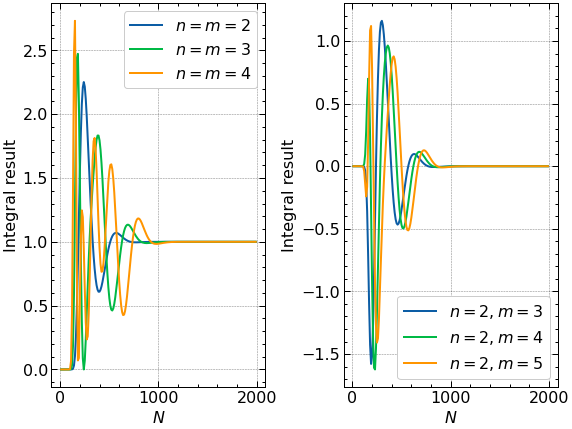

In [ ]:
def integrand(r, n, m, l):
    res = Rnl(r, n, l) * Rnl(r, m, l) * (r ** 2)
    return res


def gauss_quad():
    l = 1
    fig, ax = plt.subplots(1, 2)
    # n == m
    for n in range(2, 5):
        x = []
        y = []
        num = 10
        while num < 2000:
            I, err = fixed_quad(integrand, 0, R_MAX, args=(n, n, l), n=num)
            x.append(num)
            y.append(I)
            num += 10
        ax[0].plot(x, y)

    ax[0].legend([r'$n=m=2$', r'$n=m=3$', r'$n=m=4$'])
    ax[0].set_xlabel(r'$N$')
    ax[0].set_ylabel(r'Integral result')

    # n != m
    n = 2
    for m in range(2, 6):
        if n == m:
            continue
        x = []
        y = []
        num = 10
        while num < 2000:
            I, err = fixed_quad(integrand, 0, R_MAX, args=(n, m, l), n=num)
            x.append(num)
            y.append(I)
            num += 10
        ax[1].plot(x, y)

    ax[1].legend([r'$n=2,m=3$', r'$n=2,m=4$', r'$n=2,m=5$'])
    ax[1].set_xlabel(r'$N$')
    ax[1].set_ylabel(r'Integral result')

    fig.tight_layout(pad=.5)
    plt.show()

gauss_quad()

And indeed, we got the desire equality.



## 2. Reference - The Unperturbed Hamiltonian

To ensure our numerical calculations are correct, let's first compute the eigenvalues of the unperturbed hamiltonian:

$$ H_{nl,n^\prime l^\prime} = T_{nl,n^\prime l^\prime} + C_{nl,n^\prime l^\prime}$$

As we already know what we expect to get, it's a good practice to make sure we are on the right path.

The kinetic term $T_{nl,n^\prime l^\prime}$ can be calculated by

$$ T_{nl,n^\prime l^\prime} = \delta_{l,l^\prime} \left[\frac{1}{2} \int r^2 dr \frac{dR_{nl}}{dr} \frac{dR_{n^\prime l}}{dr} + \frac{l(l+1)}{2} \int dr R_{nl}(r)R_{n^\prime l}(r) \right]$$

where $dR_{nl}/dr$ is calculated using the fact that $\frac{d}{dx}L_{n}^{k}\left(x\right)=-L_{n-1}^{k+1}\left(x\right)$

$$ \frac{d}{dr}R_{nl}\left(r\right)=\sqrt{\left(\frac{2}{a_{0}}\right)^{3}\frac{\left(n-l-1\right)!}{\left(n+l+1\right)!}}\frac{2}{a_{0}}e^{-\rho/2}\left[l\rho^{l-1}L_{n-l-1}^{2l+2}-\rho^{l}L_{n-l-2}^{2l+3}-\frac{1}{2}\rho^{l}L_{n-l-1}^{2l+2}\right] $$

In [ ]:
def d_Rnl(r, n, l):
    rho = 2 * r
    factor = np.sqrt((8 * math.factorial(n - l - 1) / math.factorial(n + l + 1)))
    lag1 = assoc_laguerre(rho, n - l - 1, (2 * l) + 2)
    lag2 = assoc_laguerre(rho, n - l - 2, (2 * l) + 3)
    a = l * (rho**(l-1)) * lag1
    b = (rho**l) * lag2
    c = 0.5 * (rho**l) * lag1
    expression = a - b - c
    exp = np.exp(-rho / 2)
    res = factor * 2 * exp * expression
    return res


def sub_integrand_t1(r, n, l, n_prime):
    res = (r**2) * d_Rnl(r, n, l) * d_Rnl(r, n_prime, l)
    return res


def sub_integrand_t2(r, n, l, n_prime):
    res = Rnl(r, n, l) * Rnl(r, n_prime, l)
    return res


def calc_t(n, l, n_prime, l_prime):
    if l != l_prime:
        return 0
    I1, err = quad(sub_integrand_t1, 0, np.inf, args=(n, l, n_prime))
    I2, err = quad(sub_integrand_t2, 0, np.inf, args=(n, l, n_prime))
    res = (0.5 * I1) + (0.5 * l * (l + 1) * I2)
    return res

Next, the Coulomb term is given by

$$ C_{nl,n^\prime l^\prime} = -\delta_{l,l^\prime} \int r^2 dr R_{nl}(r)\frac{1}{r} R_{n^\prime l}(r) $$

In [ ]:
def sub_integrand_c(r, n, l, n_prime):
    res = r * Rnl(r, n, l) * Rnl(r, n_prime, l)
    return res


def calc_c(n, l, n_prime, l_prime):
    if l != l_prime:
        return 0
    I, err = quad(sub_integrand_c, 0, np.inf, args=(n, l, n_prime))
    res = -1 * I
    return res

Now, we can build the hamiltonian matrix `H0`, and diagonalize it in order to get the allowed energies. Then, we compare the first 10 lowest energies we got with the known results for the hydrogen atom to see how well we did

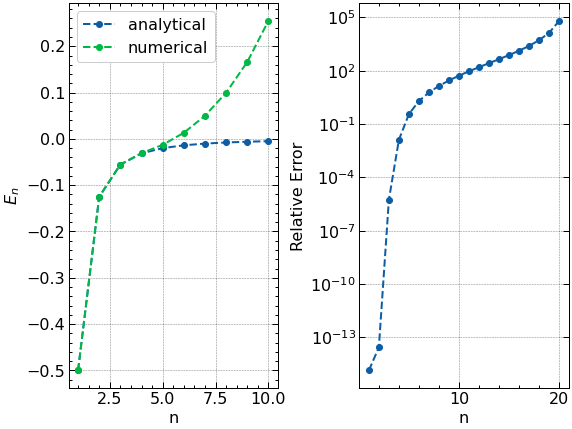

In [ ]:
def reference():
    l = 0
    l_prime = 0
    H0 = []
    for n in range(1, 21):
        row = []
        for n_prime in range(1, 21):
            res = calc_t(n,l,n_prime,l_prime) + calc_c(n,l,n_prime,l_prime)
            row.append(res)
        H0.append(row)
    eigenvals, eigenvecs = np.linalg.eig(H0)
    eigenvals.sort()
    x = []
    analytic = []
    err = []
    for n in range(1, 21):
        x.append(n)
        val = -1 / (2 * n**2)
        analytic.append(val)
        err.append(np.abs(val - eigenvals[n-1]) / np.abs(val))

    fig, ax = plt.subplots(1, 2)

    ax[0].plot(x[0:10], analytic[0:10], 'o--')
    ax[0].plot(x[0:10], eigenvals[0:10], 'o--')
    ax[0].legend(["analytical", "numerical"])
    ax[0].set_xlabel(r'n')
    ax[0].set_ylabel(r'$E_{n}$')

    ax[1].plot(x, err, 'o--')
    ax[1].semilogy()
    ax[1].set_xlabel(r'n')
    ax[1].set_ylabel(r'Relative Error')

    fig.tight_layout(pad=.5)
    plt.show()

reference()

By looking at the first 4-5 energies, it looks like we are indeed on the right way.



## 3. The Perturbed Hamiltonian

To compute the magnetic field effects on $m=0$ states we will write the magentic matrix elements as follows

$$ B_{nl,n^\prime l^\prime} = \int r^2 drd\Omega R_{nl}(r)Y_{l0}^*\left(\theta,\phi\right)r^2 \sin^2\theta R_{n^\prime l^\prime}(r) Y_{l^\prime 0}\left(\theta,\phi\right) = I_{l^\prime l}W_{nl,n^\prime l^\prime} $$

where
$$ I_{l^\prime l} = \left<l0\left|\sin^2\theta\right|l^\prime0\right> = 2\pi \int \sin\theta d\theta Y_{l0}^*\left(\theta,0\right)\sin^2\theta  Y_{l^\prime 0}\left(\theta,0\right) $$
and
$$ W_{nl,n^\prime l^\prime}=\int dr R_{nl}(r) r^4 R_{n^\prime l^\prime}(r) $$

The calculation of $W_{nl,n^\prime l^\prime}$ is straight-forward:

In [ ]:
def sub_integrand_w(r, n, l, n_prime, l_prime):
    res = (r**4) * Rnl(r,n,l) * Rnl(r,n_prime,l_prime)
    return res

To calc $I_{l^\prime l}$ we will need to do some analytical work, combining

$$ Y_{l0} = \sqrt{\frac{2l+1}{4\pi}}P_{l}\left(\cos\theta\right) $$
with
$$ \left(2l+1\right)xP_{l}=\left(l+1\right)P_{l+1} + lP_{l-1} $$
and
$$ \int dxP_{l}(x)P_{l^\prime}(x)=\delta_{l^\prime l} \frac{2}{2l+1} $$

After a little bit of math we obtain

$$ I_{l^{\prime}l}=\begin{cases}
1-\frac{\left(l+1\right)^{2}}{\left(2l+1\right)\left(2l+3\right)}-\frac{l^{2}}{4l^{2}-1} & l=l^{\prime}\\
-\frac{\left(l+1\right)\left(l+2\right)}{2l+3}\sqrt{\frac{1}{\left(2l+5\right)\left(2l+1\right)}} & l=l^{\prime}-2\\
-\frac{l\left(l-1\right)}{2l-1}\sqrt{\frac{1}{\left(2l-3\right)\left(2l+1\right)}} & l=l^{\prime}+2\\
0 & \text{otherwise}
\end{cases}$$

In [ ]:
def calc_i(l, l_prime):
    if l == l_prime:
        val = 1 - (((l+1)**2) / ((2*l+1)*(2*l+3))) - ((l**2)/(4*l**2 - 1))
    elif l == l_prime - 2:
        sqr_term = 1 / np.sqrt((2*l + 5)*(2*l + 1))
        val = - ((l+1)*(l+2)/(2*l + 3)) * sqr_term
    elif l == l_prime + 2:
        sqr_term = 1 / np.sqrt((2*l - 3)*(2*l + 1))
        val = - (l*(l-1))/(2*l - 1) * sqr_term
    else:
        val = 0
    return val

Now, we can sum both I and W to get the total magnetic field matrix element.

In [ ]:
def calc_b(n, l, n_prime, l_prime):
    w, err = quad(sub_integrand_w, 0, np.inf, args=(n,l,n_prime,l_prime))
    i = calc_i(l, l_prime)
    res = i * w
    return res

Once again, let's construct the hamiltonian `H`

In [ ]:
def get_h(gamma, n_max):
    n_vec = []
    l_vec = []
    for i in range(n_max + 1):
        for j in range(i):
            n_vec.append(i)
            l_vec.append(j)
    N = len(l_vec)
    H = [[0 for x in range(N)] for y in range(N)]

    for i in range(N):
        for j in range(N):
            H[i][j] = (calc_t(n_vec[i], l_vec[i], n_vec[j], l_vec[j]) + calc_c(n_vec[i], l_vec[i], n_vec[j], l_vec[j])
                       + ((gamma ** 2) / 8) * calc_b(n_vec[i], l_vec[i], n_vec[j], l_vec[j]))
    return H

And get the lowest 3 allowed energies

In [ ]:
def get_lower_3_energies(gamma, n_max):
    H = get_h(gamma, n_max)
    eigenvals, eigenvecs = np.linalg.eig(H)
    eigenvals.sort()
    return eigenvals[0:3]

Next, let's plot the three lowest energies as function of $\gamma$

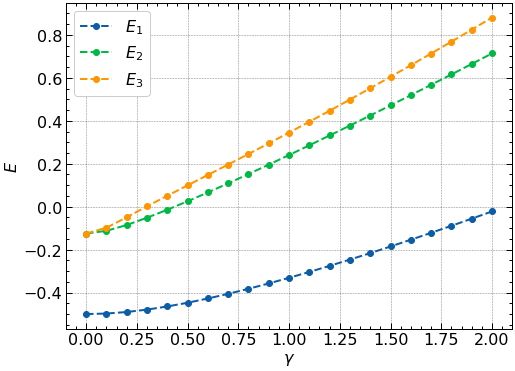

In [ ]:
E1 = [0] * GAMMA_LEN
E2 = [0] * GAMMA_LEN
E3 = [0] * GAMMA_LEN
gamma = np.linspace(0, 2, GAMMA_LEN)
delta_1 = [0] * GAMMA_LEN
delta_2 = [0] * GAMMA_LEN
delta_3 = [0] * GAMMA_LEN
for i in range(len(gamma)):
    e1, e2, e3 = get_lower_3_energies(gamma[i], N_MAX)
    E1[i] = e1
    E2[i] = e2
    E3[i] = e3
    pert_1 = -0.5 + (0.25 * (gamma[i]**2))
    pert_2 = -0.125 + (1.5 * (gamma[i]**2))
    pert_3 = -0.125 + (3.5 * (gamma[i]**2))
    delta_1[i] = np.abs(e1 - pert_1) / np.abs(pert_1)
    delta_2[i] = np.abs(e2 - pert_2) / np.abs(pert_2)
    delta_3[i] = np.abs(e3 - pert_3) / np.abs(pert_3)

plt.plot(gamma, E1, '--o', label=r'$E_{1}$')
plt.plot(gamma, E2, '--o', label=r'$E_{2}$')
plt.plot(gamma, E3, '--o', label=r'$E_{3}$')
plt.legend()
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$E$')
plt.show()

As we can clearly see from the graph, as the value of $\gamma$ increases, the energies $E_2,E_3$ splits - **Zeeman effect in action!**

### Sanity Check - Time Independent Perturbation Theory

Checking the results from a different point of view, let's compare what we got with the energies we expect to get using perturbation theory, assuming $\gamma$ as the small parameter. The perturbation potenetial is
$$ V =\frac{1}{2}\gamma L_z + \frac{1}{8}\gamma^2 r^2 \sin^2\theta $$
First, we note that $L_z\left|m=0\right> = 0$ so we will look at the remaining term. The perturbation is time-independant and we dont have degeneracy. Recall that the correspondent wave functions to the three lowest energy levels are
$$ \psi_{100}\left(r\right)	=\frac{1}{\sqrt{\pi a_{0}^{3}}}e^{-r/a_{0}} $$
$$ \psi_{200}\left(r\right)	=\frac{1}{4\sqrt{2\pi a_{0}^{3}}}\left(2-\frac{r}{a_{0}}\right)e^{-r/2a_{0}} $$
$$ \psi_{210}\left(r\right)	=\frac{1}{4\sqrt{2\pi a_{0}^{3}}}\frac{r}{a_{0}}e^{-r/2a_{0}}\cos\theta $$

To get the first order energy correction, we will calculate the perturbation expected value, i.e
$$ E_{100}^{(1)} = \left<\psi_{100}\left(r\right)\left|\frac{1}{8}\gamma^2 r^2 \sin^2\theta\right|\psi_{100}\left(r\right)\right> = \int\psi_{100}\left(r\right)^*\frac{1}{8}\gamma^2 r^2 \sin^2\theta\psi_{100}\left(r\right)d^3r = \frac{1}{4}a_0^2 $$

$$ E_{200}^{(1)} = \left<\psi_{200}\left(r\right)\left|\frac{1}{8}\gamma^2 r^2 \sin^2\theta\right|\psi_{200}\left(r\right)\right> = \int\psi_{200}\left(r\right)^*\frac{1}{8}\gamma^2 r^2 \sin^2\theta\psi_{200}\left(r\right)d^3r = \frac{7}{2}a_0^2 $$

$$ E_{210}^{(1)} = \left<\psi_{210}\left(r\right)\left|\frac{1}{8}\gamma^2 r^2 \sin^2\theta\right|\psi_{210}\left(r\right)\right> = \int\psi_{210}\left(r\right)^*\frac{1}{8}\gamma^2 r^2 \sin^2\theta\psi_{210}\left(r\right)d^3r = \frac{3}{2}a_0^2 $$

Setting $a_0=1$ we obtain

$$ E_{100}\left(\gamma\right)=-\frac{1}{2}+\frac{1}{4}\gamma^{2} ,\quad
E_{200}\left(\gamma\right)=-\frac{1}{8}+\frac{7}{2}\gamma^{2} ,\quad
E_{210}\left(\gamma\right)=-\frac{1}{8}+\frac{3}{2}\gamma^{2} $$
Plotting the error between the results we got and the energy correction from first order perturbation theory

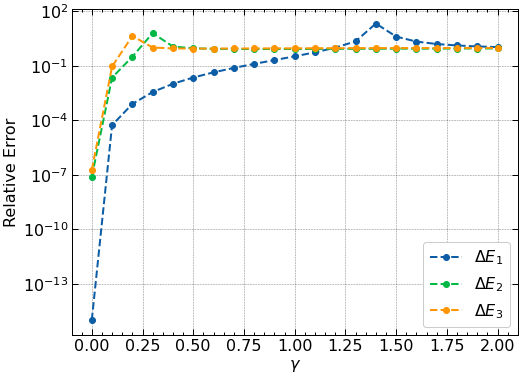

In [ ]:
plt.plot(gamma, delta_1, '--o', label=r'$\Delta E_{1}$')
plt.plot(gamma, delta_2, '--o', label=r'$\Delta E_{2}$')
plt.plot(gamma, delta_3, '--o', label=r'$\Delta E_{3}$')
plt.legend()
plt.xlabel(r'$\gamma$')
plt.ylabel(r'Relative Error')
plt.semilogy()
plt.show()

As we can clearly see, for small values of $\gamma$ we pretty much in agreement with the energies we got numerically by diagonalizing the hamiltonian `H0` we constructed. Finally, plotting the 3 lowest energies as function of $2\leq n\leq12$

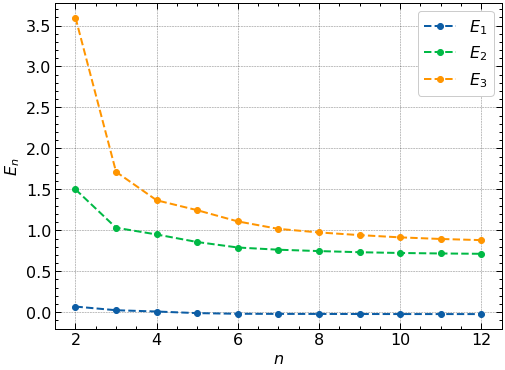

In [ ]:
gamma = 2
E1 = []
E2 = []
E3 = []
x = []
for n in range(2, N_MAX + 1):
    x.append(n)
    e1, e2, e3 = get_lower_3_energies(gamma, n)
    E1.append(e1)
    E2.append(e2)
    E3.append(e3)
plt.plot(x, E1, '--o', label=r'$E_{1}$')
plt.plot(x, E2, '--o', label=r'$E_{2}$')
plt.plot(x, E3, '--o', label=r'$E_{3}$')
plt.legend()
plt.xlabel(r'$n$')
plt.ylabel(r'$E_{n}$')
plt.show()

As we can see, by taking more values of n we converge to the values we got - another indication that our computations are correct.